# Notebook used to estimate epidemic waves

In [7]:
import pandas as pd
from functools import reduce
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('data/world_r_eff.csv',
        usecols=['country','date','R'],
        parse_dates=['date'],
        squeeze=True
        ).sort_index()

In [9]:
trend_length = 14
logic_func = lambda r: reduce(lambda x, y: x + 1 if y else 0, r)

In [12]:
df_total = pd.DataFrame(columns=['country',	'date',	'R', 'upward_slope_days', 'downward_slope_days' ])
for country in df.country.unique():
    print(country)
    df_country = df.loc[df['country'] == country]
    
    # counts number consecutive days with R>=1 for a give date
    ser = df.loc[df['country'] == country]['R'] >= 1
    df_country['upward_slope_days'] = ser.expanding().apply(logic_func)

    # counts number consecutive days with R<1 for a give date
    ser = df_country['R'] < 1
    df_country['downward_slope_days'] = ser.expanding().apply(logic_func)

    df_country = df_country[(df_country.upward_slope_days > 14) | (df_country.downward_slope_days > 14)]
    # append df to total_df
    df_total = pd.concat([df_total, df_country])

Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Brazil
Brunei
Bolivia
Bosnia and Herzegovina
Botswana
Bulgaria
Burkina Faso
Burma
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czechia
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lesotho
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Mauritania
Mauritius
Mexico
Moldova
Monaco
Mongolia
Monte

In [13]:
df_total[50:80]

,country,date,R,upward_slope_days,downward_slope_days
64,Afghanistan,2020-01-06,1.177131,65.0,0.0
65,Afghanistan,2020-02-06,1.160723,66.0,0.0
66,Afghanistan,2020-03-06,1.144655,67.0,0.0
67,Afghanistan,2020-04-06,1.127369,68.0,0.0
68,Afghanistan,2020-05-06,1.108124,69.0,0.0
69,Afghanistan,2020-06-06,1.082359,70.0,0.0
70,Afghanistan,2020-07-06,1.061787,71.0,0.0
71,Afghanistan,2020-08-06,1.039828,72.0,0.0
72,Afghanistan,2020-09-06,1.020892,73.0,0.0
73,Afghanistan,2020-10-06,1.007736,74.0,0.0


In [14]:
df_total.max()

country                           Zimbabwe
date                   2021-12-04 00:00:00
R                                 4.085288
upward_slope_days                    390.0
downward_slope_days                  401.0
dtype: object

In [77]:
# counts downward slopes and finds duration of them
ser = df_total['upward_slope_days'] > 14
count_up = df_total['upward_slope_days'] [ser & (ser != ser.shift(-1))].value_counts(normalize=True)
count_up_df = count_up.reset_index().rename(columns={'index':'duration', 'upward_slope_days':'fraction' })
count_up_df = count_up_df.round({'duration':0, 'fraction':3})
count_up_df = count_up_df.sort_values(by=['duration'])
count_up_df

,duration,fraction
12,15.0,0.016
5,16.0,0.023
0,17.0,0.032
67,18.0,0.005
6,19.0,0.019
...,...,...
117,189.0,0.002
94,210.0,0.002
120,213.0,0.002
99,216.0,0.002


In [23]:
# counts downward slopes and finds duration of them
ser = df_total['downward_slope_days'] > 14
count_down = df_total['downward_slope_days'] [ser & (ser != ser.shift(-1))].value_counts(normalize=True)
count_down_df = count_down.reset_index().rename(columns={'index':'duration','downward_slope_days':'fraction' })
count_down_df = count_down_df.round({'duration':0, 'fraction':3})
count_down_df = count_down_df.sort_values(by=['duration'])
count_down_df

,duration,fraction
1,15.0,0.037
5,16.0,0.028
58,17.0,0.005
10,18.0,0.021
2,19.0,0.030
...,...,...
101,279.0,0.002
118,323.0,0.002
74,374.0,0.002
94,379.0,0.002


[Text(0.5, 0, 'Duration (days)')]

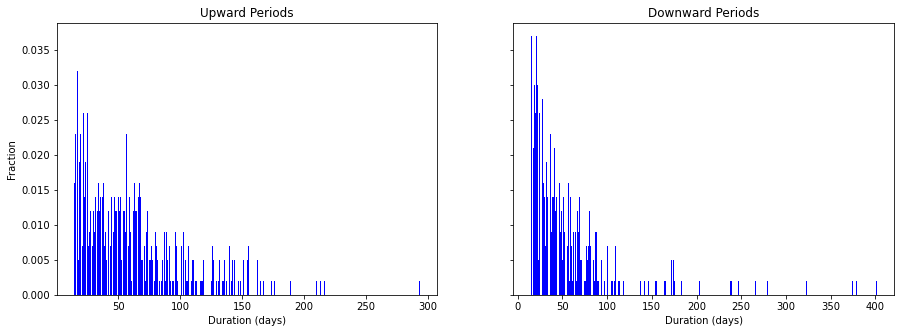

In [78]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,5))
ax[0].bar(count_up_df['duration'], count_up_df['fraction'], color='b')
ax[0].set_title('Upward Periods')
ax[0].set(xlabel='Duration (days)')
ax[0].set(ylabel='Fraction')
ax[1].bar(count_down_df['duration'], count_down_df['fraction'], color='b')
ax[1].set_title('Downward Periods')
ax[1].set(xlabel='Duration (days)')

In [70]:
count_down_df

,duration,fraction
1,15.0,0.037
5,16.0,0.028
58,17.0,0.005
10,18.0,0.021
2,19.0,0.030
...,...,...
101,279.0,0.002
118,323.0,0.002
74,374.0,0.002
94,379.0,0.002


In [110]:
ser = df_total['upward_slope_days'] > 14
count_up_dist = df_total['upward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'upward_slope_days':'days'})
count_up_dist['slope'] = pd.Series(['Upward' for _ in range(len(count_up_dist))])

ser = df_total['downward_slope_days'] > 14
count_down_dist = df_total['downward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'downward_slope_days':'days'})
count_down_dist['slope'] = pd.Series(['Downward' for _ in range(len(count_up_dist))])

df_dist = count_up_dist.append(count_down_dist)

<Figure size 842.4x595.44 with 0 Axes>

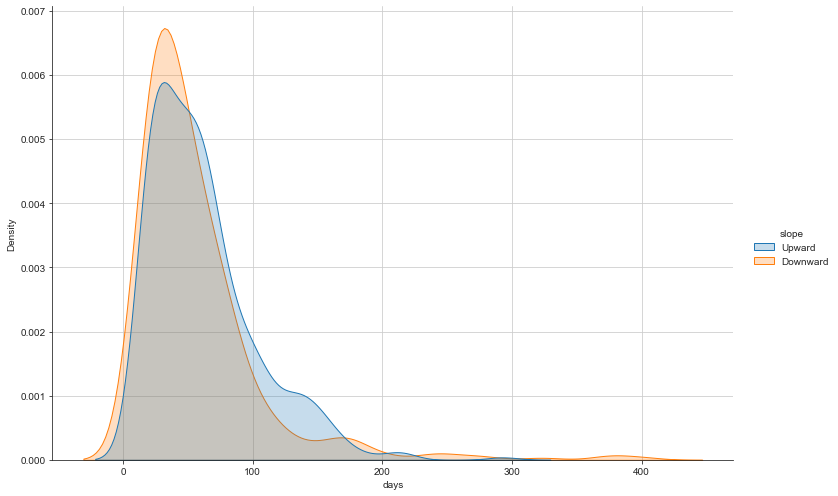

In [162]:
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
sns.displot(df_dist, x='days', hue='slope', kind='kde', fill=True, height=7, aspect=1.5)
plt.grid()
plt.show()